In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences, split_in_subsequences
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 256
EPOCHS = 100
NORMALISE_DATA = True
STEP_SIZE = 1
SEQ_END = 1800

# Define common model, loss and optimizer

In [6]:
INPUT_DIM = len(YOKED_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 3     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [7]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

100%|██████████| 400/400 [00:06<00:00, 62.13it/s]


In [8]:
exp1_trials = split_in_subsequences(exp1_trials, seq_size=900)
exp2_mass_trials = split_in_subsequences(exp2_mass_trials, seq_size=900)
exp2_force_trials = split_in_subsequences(exp2_force_trials, seq_size=900)

In [9]:
yoked_trials = exp1_trials + exp2_mass_trials + exp2_force_trials

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [10]:
len(yoked_trials)

2623

In [11]:
indices = np.arange(len(yoked_trials))
train_indices = np.random.choice(indices, 2200, replace=False)
val_indices = np.random.choice(list(set(indices) - set(train_indices)), 200, replace=False)
test_indices = list(set(indices) - set(train_indices) - set(val_indices))

In [12]:
train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

In [13]:
loaders, scaler = prepare_dataset([train_trials, val_trials], training_columns=YOKED_TRAINING_COLS, 
                                  class_columns=MASS_CLASS_COLS, batch_size=BATCH_SIZE, 
                                  normalise_data=NORMALISE_DATA)

100%|██████████| 200/200 [00:00<00:00, 493.03it/s]


In [14]:
train_loader, val_loader = loaders

In [15]:
class_proportions(train_loader)
class_proportions(val_loader)

[778 631 791]
Majority class:  0.35954545454545456
[80 52 68]
Majority class:  0.4


## Define model, loss and optimizer

In [18]:
model, error, optimizer = initialise_model(network_dims, dropout=0, lr=0.01)

## Train model and plot loss and accuracy

In [ ]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS,
                                                           seq_end=SEQ_END, step_size=STEP_SIZE)


  0%|          | 0/100 [00:00<?, ?it/s]
Train_loss (1.10)	 Train_acc (39.23)	 Val_acc (41.50):   0%|          | 0/100 [00:01<?, ?it/s]
Train_loss (1.10)	 Train_acc (39.23)	 Val_acc (41.50):   1%|          | 1/100 [00:01<01:42,  1.03s/it]
Train_loss (1.09)	 Train_acc (40.68)	 Val_acc (40.50):   1%|          | 1/100 [00:02<01:42,  1.03s/it]
Train_loss (1.09)	 Train_acc (40.68)	 Val_acc (40.50):   2%|▏         | 2/100 [00:02<01:42,  1.05s/it]
Train_loss (1.08)	 Train_acc (41.23)	 Val_acc (38.50):   2%|▏         | 2/100 [00:03<01:42,  1.05s/it]
Train_loss (1.08)	 Train_acc (41.23)	 Val_acc (38.50):   3%|▎         | 3/100 [00:03<01:41,  1.04s/it]
Train_loss (1.07)	 Train_acc (42.45)	 Val_acc (41.00):   3%|▎         | 3/100 [00:04<01:41,  1.04s/it]
Train_loss (1.07)	 Train_acc (42.45)	 Val_acc (41.00):   4%|▍         | 4/100 [00:04<01:39,  1.04s/it]
Train_loss (1.06)	 Train_acc (44.73)	 Val_acc (42.00):   4%|▍         | 4/100 [00:05<01:39,  1.04s/it]
Train_loss (1.06)	 Train_acc (44.73)	 Va

Train_loss (0.53)	 Train_acc (82.77)	 Val_acc (42.50):  38%|███▊      | 38/100 [00:45<01:16,  1.24s/it]
Train_loss (0.53)	 Train_acc (82.77)	 Val_acc (42.50):  39%|███▉      | 39/100 [00:45<01:16,  1.25s/it]
Train_loss (0.41)	 Train_acc (85.32)	 Val_acc (38.00):  39%|███▉      | 39/100 [00:46<01:16,  1.25s/it]
Train_loss (0.41)	 Train_acc (85.32)	 Val_acc (38.00):  40%|████      | 40/100 [00:46<01:14,  1.25s/it]
Train_loss (0.38)	 Train_acc (88.91)	 Val_acc (34.50):  40%|████      | 40/100 [00:47<01:14,  1.25s/it]
Train_loss (0.38)	 Train_acc (88.91)	 Val_acc (34.50):  41%|████      | 41/100 [00:47<01:14,  1.26s/it]
Train_loss (0.29)	 Train_acc (91.14)	 Val_acc (36.00):  41%|████      | 41/100 [00:48<01:14,  1.26s/it]
Train_loss (0.29)	 Train_acc (91.14)	 Val_acc (36.00):  42%|████▏     | 42/100 [00:48<01:10,  1.22s/it]
Train_loss (0.23)	 Train_acc (92.32)	 Val_acc (33.00):  42%|████▏     | 42/100 [00:49<01:10,  1.22s/it]
Train_loss (0.23)	 Train_acc (92.32)	 Val_acc (33.00):  43%|████

Train_loss (0.04)	 Train_acc (99.14)	 Val_acc (35.00):  76%|███████▌  | 76/100 [01:29<00:27,  1.15s/it]
Train_loss (0.04)	 Train_acc (99.14)	 Val_acc (35.00):  77%|███████▋  | 77/100 [01:29<00:26,  1.14s/it]
Train_loss (0.06)	 Train_acc (98.14)	 Val_acc (33.50):  77%|███████▋  | 77/100 [01:30<00:26,  1.14s/it]
Train_loss (0.06)	 Train_acc (98.14)	 Val_acc (33.50):  78%|███████▊  | 78/100 [01:30<00:24,  1.13s/it]
Train_loss (0.12)	 Train_acc (95.41)	 Val_acc (37.50):  78%|███████▊  | 78/100 [01:31<00:24,  1.13s/it]
Train_loss (0.12)	 Train_acc (95.41)	 Val_acc (37.50):  79%|███████▉  | 79/100 [01:31<00:23,  1.13s/it]
Train_loss (0.24)	 Train_acc (91.09)	 Val_acc (36.50):  79%|███████▉  | 79/100 [01:32<00:23,  1.13s/it]
Train_loss (0.24)	 Train_acc (91.09)	 Val_acc (36.50):  80%|████████  | 80/100 [01:32<00:22,  1.13s/it]
Train_loss (0.33)	 Train_acc (93.32)	 Val_acc (38.00):  80%|████████  | 80/100 [01:34<00:22,  1.13s/it]
Train_loss (0.33)	 Train_acc (93.32)	 Val_acc (38.00):  81%|████

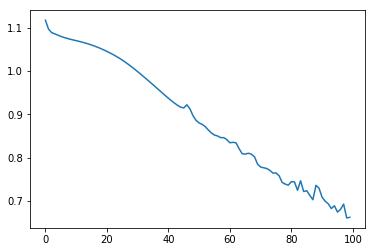

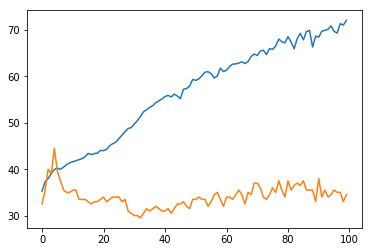

In [30]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [20]:
max(epoch_accuracies[1])

42.5

## Save model and scaler

In [ ]:
torch.save(best_model.state_dict(), "models/yoked_mass_model.pt")
joblib.dump(scaler, "scalers/yoked_mass_scaler.sk")

## Load model and evaluate

model_path = "models/yoked_mass_model.pt"
scaler_path = "scalers/yoked_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, YOKED_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [ ]:
loaders, scaler = prepare_dataset([train_trials, val_trials], class_columns=FORCE_CLASS_COLS, 
                                  training_columns=YOKED_TRAINING_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

In [ ]:
train_loader, val_loader = loaders

In [ ]:
class_proportions(train_loader)
print()
class_proportions(val_loader)

## Define model, loss and optimizer

In [ ]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [ ]:
model.train()
epoch_losses, epoch_accuracies, _ = training_loop(model, optimizer, error, train_loader, 
                                                  val_loader, EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)

In [ ]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [ ]:
max(epoch_accuracies[1])

## Save model and scaler

torch.save(best_model.state_dict(), "models/passive_force_model.pt")
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

## Evaluate saved model

model_path = "models/passive_force_model.pt"
scaler_path = "scalers/passive_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path)